In [1]:
import heapq
import os.path
import re
from glob import glob
from operator import itemgetter
from optparse import OptionParser

import matplotlib.pyplot as plt
import numpy as np
import torch
from dataset import UFData
from momentum_model import MomentumModel
from network import SimpleNet
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

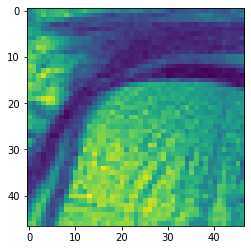

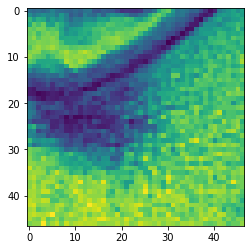

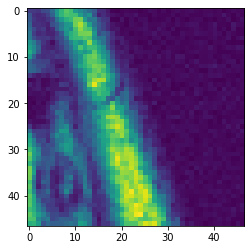

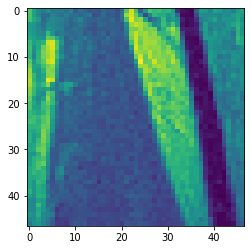

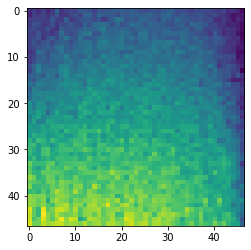

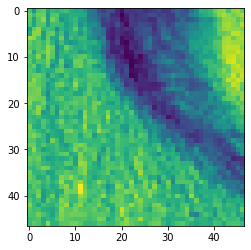

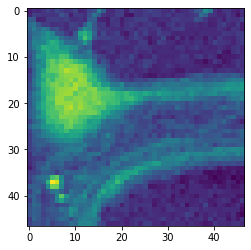

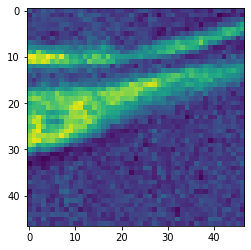

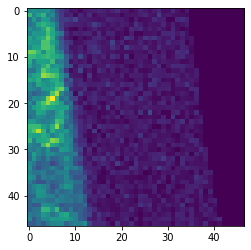

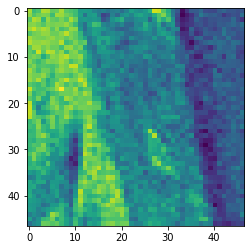

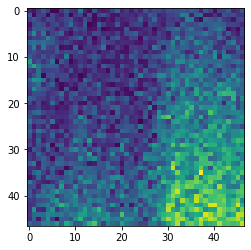

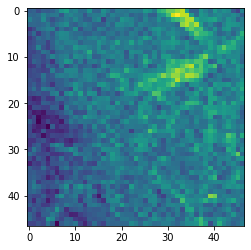

In [2]:
input_paths = [
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1000153_4.npy",
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1001059_2.npy",
        ]
patch_centers = [(300, 120), (310, 200), (280, 290),
                         (450, 120), (95, 180), (200, 220)]


for path in input_paths:
    im = np.load(path)
    for center in patch_centers:
        plt.figure()
        patch = im[center[0] - 47//2:center[0] + 47//2+1, center[1] - 47//2:center[1] + 47//2+1]
        plt.imshow(np.abs(patch))

### Set Args

In [3]:
class Args:
    def __init__(self):
        self.gpu = 0
        self.checkpoint = None
        self.logdir = "/mikQNAP/anacis/ufloss_checkpoints/randomtopbotclip_randomnormalize_jitterblur/temp1"
        self.datadir = "/mikQNAP/NYU_knee_data/knee_train_h5/data/train"
        self.magnitude = True
        self.fastmri = True

### Load Model

In [4]:
torch.backends.cudnn.benchmark = True
args = Args()

device = torch.device(f'cuda:{args.gpu}' if args.gpu is not None else 'cpu')
if not args.checkpoint:
    checkpoint = sorted(glob(os.path.join(args.logdir, 'checkpoints/*')),
                        key=lambda x: int(re.match(".*[a-z]+(\d+).pth", x).group(1)))[-1]
else:
    checkpoint = args.checkpoint

checkpoint_number = re.match(".*[a-z]+(\d+).pth", checkpoint).group(1)
ksnet = MomentumModel(SimpleNet, magnitude=True)

print(f"Loading checkpoint from: {checkpoint}")
# Loading on cpu before transferring to model
ksnet.load_state_dict(torch.load(checkpoint, "cpu")["state_dict"])

ksnet = ksnet.target_network
ksnet.to(device)
ksnet.eval()

save_dir = os.path.join(args.logdir, "results")
os.makedirs(save_dir, exist_ok=True)

Using parameters:
   Momentum: 0.99975
   Temperature: 1.0
Loading checkpoint from: /mikQNAP/anacis/ufloss_checkpoints/randomtopbotclip_randomnormalize_jitterblur/temp1/checkpoints/ckpt200.pth


### Prepare Data

In [5]:
# Run every image on the dataset, find the closest embeddings to each reference patch embeddings and keep the top 20
dataset = UFData(args.datadir, max_offset=(0, 0), magnitude=args.magnitude, device=device, fastmri=args.fastmri)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False, num_workers=20)

# Run reference image through network
if args.fastmri:
    input_paths = [
        "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1000153_4.npy",
        "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1001059_2.npy",
    ]
    patch_centers = [(300, 120), (310, 200), (280, 290),
                     (450, 120), (95, 180), (200, 220)]

Using data from: /mikQNAP/NYU_knee_data/knee_train_h5/data/train
Found 5120 image paths.


In [6]:
def get_embed_sprite(images, embeddings):
    patch_size=47
    jump=8
    sample_rate=0.01

    if not args.magnitude:
        images = torch.norm(images, dim=1, keepdim=True)

    # Get embedding indices to collect (and image patches top left corners by multiplying (x, y) by jump)
    index_n, index_x, index_y = torch.meshgrid(torch.arange(embeddings.shape[0]),
                                               torch.arange(embeddings.shape[1]),
                                               torch.arange(embeddings.shape[2]))
    index_n, index_x, index_y = torch.flatten(index_n), torch.flatten(index_x), torch.flatten(index_y)
    random_choice = torch.randperm(len(index_n))[:int(sample_rate * len(index_n))]
    index_n, index_x, index_y = index_n[random_choice], index_x[random_choice], index_y[random_choice]

    # Collect images and respective embeddings
    images = torch.stack([images[s_n, :, s_x: s_x + patch_size, s_y: s_y + patch_size]
                          for s_n, s_x, s_y in zip(index_n, index_x * jump, index_y * jump)], 0)
    embeddings = torch.stack([embeddings[s_n, s_x, s_y] for s_n, s_x, s_y in zip(index_n, index_x, index_y)], 0)

    return images, embeddings

In [18]:
# Get Reference Embeddings

with torch.no_grad():

    start, jump = 23, 8
    reference_image_size = dataset[0][0].shape


    all_reference_embeddings = []
    all_reference_images = []
    for input_path in input_paths:

        reference_image_tensor = np.load(input_path)[:640, :320]
        reference_image_tensor = torch.tensor(np.abs(reference_image_tensor),
                                              dtype=torch.float).to(device)[None, None]  # [1, 1, 640, 372]

        reference_embeddings = ksnet(reference_image_tensor)[0].permute(0, 2, 3, 1)  #[1, 128, 75, 41] 
        
        image, embeddings = get_embed_sprite(reference_image_tensor.detach(), reference_embeddings.detach())

        all_reference_embeddings.append(embeddings)
        all_reference_images.append(image)
    
    all_reference_embeddings_tensor = torch.cat(all_reference_embeddings)
    all_reference_images_tensor = torch.cat(all_reference_images)

    print(all_reference_embeddings_tensor.shape)
    print(all_reference_images_tensor.shape)

torch.Size([52, 128])
torch.Size([52, 1, 47, 47])


In [26]:
# Get Data Embeddings
all_data_embeddings = []
all_data_images = []

with torch.no_grad():
    for index, images in enumerate(tqdm(dataloader, "Batch")):
        for image in images:  # image1 and image2 with different augmentations
            image = image.to(device)
            embeddings = ksnet(image)[0].permute(0, 2, 3, 1)
            
            # Get image sprites and their embeddings
            image, embeddings = get_embed_sprite(image.detach(), embeddings.detach())

            all_data_embeddings.append(embeddings)
            all_data_images.append(image)
        if index == 5:
            break
            
    all_data_embeddings_tensor = torch.cat(all_data_embeddings)
    all_data_images_tensor = torch.cat(all_data_images)

Batch:   0%|          | 5/1024 [00:11<37:27,  2.21s/it]  


In [27]:
#concatenate references and data 
all_embeddings_tensor = torch.cat([all_reference_embeddings_tensor, all_data_embeddings_tensor])
all_images_tensor = torch.cat([all_reference_images_tensor, all_data_images_tensor])

print(all_embeddings_tensor.shape, all_images_tensor.shape)

torch.Size([1624, 128]) torch.Size([1624, 1, 47, 47])


In [23]:
all_images_tensor.device

device(type='cuda', index=0)

In [29]:
#log embeddings
tag="embeddings"
summary_writer = SummaryWriter("/home/anacis/visualize", flush_secs=1)
summary_writer.add_embedding(all_embeddings_tensor, label_img=all_images_tensor, global_step=0, tag=tag)
